# Symphony with scATAC-seq data

## setup

In [1]:
#from libs.R in symphony tutorial
suppressMessages({
    # Analysis
    library(symphony)
    library(harmony)
    library(singlecellmethods)
    library(irlba)
    #library(tidyverse)
    library(tidyr)
    library(data.table)
    library(matrixStats)
    library(Matrix)
    library(plyr)
    library(dplyr)

    # Plotting
    library(ggplot2)
    library(ggthemes)
    library(ggrastr)
    library(RColorBrewer)
    library(patchwork)
    library(ggpubr)
})

In [2]:
library(repr)
library(Seurat) #for LogNormalize

In [3]:
buildReferenceFromHarmonyObj2 <- function(harmony_obj,
                           metadata,
                           varpeaks_IDF,            #KW changed from vargenes_means_sds
                           pca_loadings,            # peaks x PCs
                           verbose = TRUE, 
                           do_umap = TRUE, 
                           save_uwot_path = NULL,
                           umap_min_dist = 0.1) {
    set.seed(111) # for reproducibility
    if (verbose) message('Save metadata, vargenes (S), and loadings (U)')
    res = list(meta_data = metadata)
    res$varpeaks = varpeaks_IDF #KW res$vargenes = vargenes_means_sds
    res$loadings = pca_loadings
    if(verbose) message('Save R, Z_orig, Z_corr, and betas from Harmony object')
    res$R = harmony_obj$R
    res$Z_orig = harmony_obj$Z_orig
    res$Z_corr = harmony_obj$Z_corr
    #res$betas = harmony::moe_ridge_get_betas(harmony_obj) #KW newest Harmony version only
    if(verbose) message('Calculate final L2 normalized reference centroids (Y_cos)')
    res$centroids = t(cosine_normalize_cpp(harmony_obj$R %*% t(harmony_obj$Z_corr), 1))
    if(verbose) message('Calculate reference compression terms (Nr and C)')
    res$cache = compute_ref_cache(res$R, res$Z_corr)
    # Add row and column names
    colnames(res$Z_orig) = row.names(metadata)
    rownames(res$Z_orig) = paste0("PC_", seq_len(nrow(res$Z_corr)))
    colnames(res$Z_corr) = row.names(metadata)
    rownames(res$Z_corr) = paste0("harmony_", seq_len(nrow(res$Z_corr)))
    # Compute centroids in harmony PC space
    cluster_sizes = res$cache[[1]] %>% as.matrix()
    centroid_sums = t(res$Z_corr %*% t(res$R)) %>% as.data.frame()
    centroids_pc = sweep(centroid_sums, 1, cluster_sizes, "/")
    colnames(centroids_pc) = paste0("harmony_", seq_len(nrow(res$Z_corr)))
    rownames(centroids_pc) = paste0("centroid_", seq_len(nrow(res$R)))
    res$centroids_pc = centroids_pc
    if (do_umap) {
        if (verbose) message('UMAP')
        umap = uwot::umap(
            t(res$Z_corr), n_neighbors = 30, learning_rate = 0.5, init = "laplacian", 
            metric = 'cosine', fast_sgd = FALSE, n_sgd_threads = 1, # for reproducibility
            min_dist = umap_min_dist, n_threads = 4, ret_model = TRUE
        )
        res$umap$embedding = umap$embedding
        colnames(res$umap$embedding) = c('UMAP1', 'UMAP2')
        # Since the nn-index component of the uwot model is not able to be saved as an 
        # object, we save the uwot model at a user-defined path.
        if (!is.null(save_uwot_path)) {
            # If file already exists, delete it (otherwise will result in an error)
            if (file.exists(save_uwot_path)) {
                if (verbose) message(paste('File already exists at that path... overwriting...'))
                file.remove(save_uwot_path)
            }
            model = uwot::save_uwot(umap, file = save_uwot_path, unload = FALSE, verbose = FALSE)
            res$save_uwot_path = save_uwot_path
            if (verbose) message(paste('Saved uwot model'))
        }
    }
    if (verbose) message('Finished nicely.')
    return(res)
}
environment(buildReferenceFromHarmonyObj2) <- asNamespace("symphony")

In [4]:
mapQuery2 <- function (exp_query, metadata_query, ref_obj, vars = NULL, verbose = TRUE, 
    do_normalize = FALSE, do_umap = TRUE, sigma = 0.1) 
{
    if (do_normalize) {
        if (verbose) 
            message("Normalizing")
        exp_query = normalizeData(exp_query, 10000, "log")
    }
    
    #KW changed ref_obj$vargenes to ref_obj$varpeaks and means/sds to TF-IDF
    if (verbose) 
        message("Normalizing and synchronizing query peak counts")
    idx_shared_peaks = which(names(ref_obj$varpeaks) %in% rownames(exp_query))
    shared_peaks_IDF = ref_obj$varpeaks[idx_shared_peaks]
    if (verbose) 
        message("Found ", length(shared_peaks_IDF), " reference variable peaks in query dataset")
    exp_query_scaled_res = TF.IDF_multOut(exp_query[names(shared_peaks_IDF),],refIDF = shared_peaks_IDF) #KW
    exp_query_scaled_res$norm <- LogNormalize(exp_query_scaled_res$norm) #KW 
    exp_query_scaled = as.matrix(exp_query_scaled_res$norm) #KW
    exp_query_scaled_sync = matrix(0, nrow = length(ref_obj$varpeaks), ncol = ncol(exp_query))
    exp_query_scaled_sync[idx_shared_peaks, ] = exp_query_scaled
    rownames(exp_query_scaled_sync) = ref_obj$varpeaks
    colnames(exp_query_scaled_sync) = colnames(exp_query)
    
    
    if (verbose) 
        message("Project query cells using reference gene loadings")
    Z_pca_query = t(ref_obj$loadings) %*% exp_query_scaled_sync
    
    
    if (verbose) 
        message("Clustering query cells to reference centroids")
    Z_pca_query_cos = cosine_normalize_cpp(Z_pca_query, 2)
    R_query = soft_cluster(ref_obj$centroids, Z_pca_query_cos, sigma)
    
    
    if (verbose) 
        message("Correcting query batch effects")
    if (!is.null(vars)) {
        design = droplevels(metadata_query)[, vars] %>% as.data.frame()
        onehot = design %>% purrr::map(function(.x) {
            if (length(unique(.x)) == 1) {
                rep(1, length(.x))
            }
            else {
                stats::model.matrix(~0 + .x)
            }
        }) %>% purrr::reduce(cbind)
        Xq = cbind(1, intercept = onehot) %>% t()
    }
    else {
        Xq = Matrix(rbind(rep(1, ncol(Z_pca_query)), rep(1, ncol(Z_pca_query))), 
            sparse = TRUE)
    }
    Zq_corr = moe_correct_ref(as.matrix(Z_pca_query), as.matrix(Xq), 
        as.matrix(R_query), as.matrix(ref_obj$cache[[1]]), as.matrix(ref_obj$cache[[2]]))
    colnames(Z_pca_query) = row.names(metadata_query)
    rownames(Z_pca_query) = paste0("PC_", seq_len(nrow(Zq_corr)))
    colnames(Zq_corr) = row.names(metadata_query)
    rownames(Zq_corr) = paste0("harmony_", seq_len(nrow(Zq_corr)))
    
    
    umap_query = NULL
    if (do_umap & !is.null(ref_obj$save_uwot_path)) {
        if (verbose) 
            message("UMAP")
        ref_umap_model = uwot::load_uwot(ref_obj$save_uwot_path, 
            verbose = FALSE)
        umap_query = uwot::umap_transform(t(Zq_corr), ref_umap_model)
        colnames(umap_query) = c("UMAP1", "UMAP2")
    }
    if (verbose) 
        message("All done!")
    return(list(exp = exp_query, meta_data = metadata_query,
                Z = Zq_corr, Zq_pca = Z_pca_query, R = R_query, Xq = Xq, 
                umap = umap_query))
}
environment(mapQuery2) <- asNamespace("symphony")

In [5]:
#KW adapted from Seurat TF.IDF function
TF.IDF_multOut <- function(data,verbose = TRUE, refIDF = NULL){
    if (is.data.frame(x = data)) {
        data <- as.matrix(x = data)
    }
    if (!inherits(x = data, what = "dgCMatrix")) {
        data <- as(object = data, Class = "dgCMatrix")
    }
    if (verbose) {
        message("Performing TF-IDF normalization")
    }
    
    res <- list()
    
    npeaks <- colSums(x = data)
    tf <- t(x = t(x = data)/npeaks)
    
    #KW added option to input IDF vector
    if(is.null(refIDF)){
        if (verbose) {
            message("Using IDF calculated from current data")
        }
        idf <- ncol(x = data)/rowSums(x = data)
    } else {
        if (verbose) {
            message("Using provided IDF")
        }
        idf <- refIDF
    }
    
    norm.data <- Diagonal(n = length(x = idf), x = idf) %*% tf
    norm.data[is.na(norm.data)] <- 0 #KW changed b/c errored: norm.data[which(x = is.na(x = norm.data))] <- 0
    
    #KW added more outputs
    res$TF <- tf
    res$IDF <- idf
    res$norm <- norm.data
    
    return(res)
}

## inputs

* Data from [Buenrostro et al., Cell, 2018](https://www.sciencedirect.com/science/article/pii/S009286741830446X)
    * Cells are colored by original colors used here (converted to hex)
* Initial processing done as in the [Chen et al., Genome Biology, 2019](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-019-1854-5) benchmarking paper
    * Commands to get the fragment_counts SummarizedExperiment run on our cluster from their [jupyter notebook](https://github.com/pinellolab/scATAC-benchmarking/blob/master/Real_Data/Buenrostro_2018/run_methods/chromVAR/chromVAR_buenrostro2018_kmers.ipynb)
    * Cell type from metadata used here (cellType). Cell types defined from cell name also in metadata table (buenCT).
    * Donor defined from cell name
* We subsequently exported the peaks x cells matrix and binarized it
* We split up reference and query datasets by cells associated to a single donor
    * Query donor: BM1214
    * Reference donors: everything else
* Peaks are common between query and reference peaks x cells matrix

In [6]:
query_donor <- 'BM1214'
cellType_col <- 'cellType'
ref_pxc_file <- './inputs/Buenrostro_HSC_2018_not-BM1214_ref_binary.rds'
query_pxc_file <- './inputs/Buenrostro_HSC_2018_BM1214_query_binary.rds'
cell_metadata_file <- './inputs/Buenrostro_HSC_2018_metadata.rds'
cell_color_file <- './inputs/Buenrostro_HSC_2018_colors_newCT.txt'
all(file.exists(c(ref_pxc_file,query_pxc_file,cell_metadata_file,cell_color_file)))

[1] TRUE

In [7]:
outDir <- './plots/'
dir.create(outDir,showWarnings=FALSE)
prefix <- query_donor

In [8]:
ref_pxc_full <- readRDS(ref_pxc_file)
query_pxc <- readRDS(query_pxc_file)
cell_metadata <- readRDS(cell_metadata_file)

In [9]:
all(colnames(ref_pxc_full) %in% rownames(cell_metadata))
all(colnames(query_pxc) %in% rownames(cell_metadata))

[1] TRUE

[1] TRUE

In [10]:
cell_color_df <- read.table(cell_color_file,sep='\t',header=FALSE,stringsAsFactors=FALSE,comment.char='')
cell_color <- cell_color_df$V2
names(cell_color) <- cell_color_df$V1
cell_color['UNK'] <- 'black' #since I use grey as my non-important color!
cell_color['GMP'] <- '#cc8200' #to further differentiate CMP color from GMP color

In [11]:
identical(sort(unique(cell_metadata[,cellType_col])),sort(names(cell_color)))

[1] TRUE

## subset metadata

In [12]:
ref_metadata <- cell_metadata[colnames(ref_pxc_full),]
query_metadata <- cell_metadata[colnames(query_pxc),]

## feature selection

In [13]:
var_peaks = vargenes_vst(ref_pxc_full, groups = as.character(ref_metadata[['donor']]), topn = 2000)
ref_pxc = ref_pxc_full[var_peaks, ]
dim(ref_pxc)

[1] 6320 1736

## TF-IDF

In [14]:
ref_pxc_norm_res <- TF.IDF_multOut(ref_pxc)
ref_pxc_norm <- LogNormalize(ref_pxc_norm_res$norm)
ref_IDF <- ref_pxc_norm_res$IDF

Performing TF-IDF normalization

Using IDF calculated from current data



## SVD

In [15]:
set.seed(0)
s = irlba(ref_pxc_norm, nv = 20)
Z_pca_ref = diag(s$d) %*% t(s$v) # [pcs by cells]
loadings = s$u

In [16]:
dim(Z_pca_ref)
dim(loadings)

[1]   20 1736

[1] 6320   20

## harmony

In [17]:
set.seed(0)
ref_harmObj = harmony::HarmonyMatrix(
        data_mat = t(Z_pca_ref),  ## PCA embedding matrix of cells
        meta_data = ref_metadata, ## dataframe with cell labels
        theta = c(2),             ## cluster diversity enforcement
        vars_use = c('donor'),    ## variable to integrate out
        nclust = 100,             ## number of clusters in Harmony model
        max.iter.harmony = 20,
        return_object = TRUE,     ## return the full Harmony model object
        do_pca = FALSE            ## don't recompute PCs
)

Harmony 1/20

Harmony 2/20

Harmony 3/20

Harmony converged after 3 iterations



## symphony reference

In [18]:
# Compress a Harmony object into a Symphony reference
reference = buildReferenceFromHarmonyObj2(
                           ref_harmObj,            # output object from HarmonyMatrix()
                           ref_metadata,           # reference cell metadata
                           ref_IDF,                # peak names, IDF for normalization
                           loadings,               # peaks x PCs matrix
                           verbose = TRUE,         # verbose output
                           do_umap = TRUE,         # Set to TRUE only when UMAP model was saved for reference
                           save_uwot_path = paste(sep='',prefix,'_uwot_model_1'))

Save metadata, vargenes (S), and loadings (U)

Save R, Z_orig, Z_corr, and betas from Harmony object

Calculate final L2 normalized reference centroids (Y_cos)

Calculate reference compression terms (Nr and C)

UMAP

Warning message:
“invalid uid value replaced by that for user 'nobody'”
Saved uwot model

Finished nicely.



In [19]:
str(reference)

List of 11
 $ meta_data     :'data.frame':	1736 obs. of  5 variables:
  ..$ cell     : chr [1:1736] "singles-BM0828-HSC-fresh-151027-1" "singles-BM0828-HSC-fresh-151027-2" "singles-BM0828-HSC-fresh-151027-3" "singles-BM0828-HSC-fresh-151027-4" ...
  ..$ buenCT   : chr [1:1736] "HSC" "HSC" "HSC" "HSC" ...
  ..$ cellType : chr [1:1736] "HSC" "HSC" "HSC" "HSC" ...
  ..$ donor    : chr [1:1736] "BM0828" "BM0828" "BM0828" "BM0828" ...
  ..$ readDepth: int [1:1736] 10125 26250 27188 39027 23478 10666 4123 15577 29594 3969 ...
 $ varpeaks      : Named num [1:6320] 3.06 3.61 8.51 2.86 3.12 ...
  ..- attr(*, "names")= chr [1:6320] "chr1:6052293-6052742" "chr1:10270236-10270685" "chr1:11753147-11753596" "chr1:15851029-15851478" ...
 $ loadings      : num [1:6320, 1:20] -0.01519 -0.01393 -0.00841 -0.01584 -0.0151 ...
 $ R             : num [1:100, 1:1736] 0.01 0.01 0.01 0.01 0.01 ...
 $ Z_orig        : num [1:20, 1:1736] -29.21 2.21 5.06 2.32 -7.05 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$

In [20]:
dim(reference$Z_corr)
reference$Z_corr[1:5, 1:5]

[1]   20 1736

,singles-BM0828-HSC-fresh-151027-1,singles-BM0828-HSC-fresh-151027-2,singles-BM0828-HSC-fresh-151027-3,singles-BM0828-HSC-fresh-151027-4,singles-BM0828-HSC-fresh-151027-5
harmony_1,-27.9209914,-32.79182631,-34.8497656,-39.9162865,-34.896746
harmony_2,1.4478778,-0.34201955,0.5941182,0.9804134,1.839913
harmony_3,6.6458415,1.23604932,8.0817433,6.0307372,4.518106
harmony_4,0.1599619,7.07374181,-3.0294746,-3.2395713,1.471639
harmony_5,-3.0789668,-0.04120729,-3.9553340,-4.5180576,-3.825277


In [21]:
umap_labels = cbind(ref_metadata, reference$umap$embedding)
head(umap_labels)

,cell,buenCT,cellType,donor,readDepth,UMAP1,UMAP2
,<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>
singles-BM0828-HSC-fresh-151027-1,singles-BM0828-HSC-fresh-151027-1,HSC,HSC,BM0828,10125,0.4552277,-2.753091
singles-BM0828-HSC-fresh-151027-2,singles-BM0828-HSC-fresh-151027-2,HSC,HSC,BM0828,26250,-0.3824860,-2.236433
singles-BM0828-HSC-fresh-151027-3,singles-BM0828-HSC-fresh-151027-3,HSC,HSC,BM0828,27188,1.7696195,-2.464359
singles-BM0828-HSC-fresh-151027-4,singles-BM0828-HSC-fresh-151027-4,HSC,HSC,BM0828,39027,1.7719908,-2.351128
singles-BM0828-HSC-fresh-151027-5,singles-BM0828-HSC-fresh-151027-5,HSC,HSC,BM0828,23478,0.5069354,-2.634720
singles-BM0828-HSC-fresh-151027-6,singles-BM0828-HSC-fresh-151027-6,HSC,HSC,BM0828,10666,-0.5633664,-2.416300


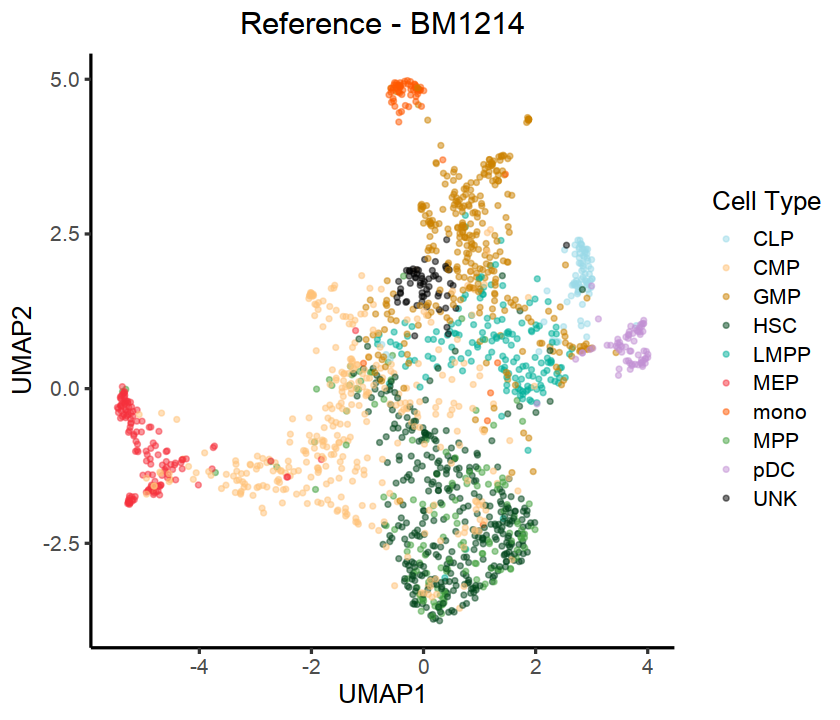

In [22]:
options(repr.plot.height=6,repr.plot.width=7)
g <- ggplot(umap_labels,aes_string(x='UMAP1',y='UMAP2',color=cellType_col)) + geom_point(size=1,alpha=0.5) +
        theme_classic(base_size=15) + scale_color_manual(values=cell_color) + labs(color='Cell Type') + 
        ggtitle(paste('Reference -',prefix)) + theme(plot.title = element_text(hjust = 0.5))
print(g)
ggsave(paste(sep='',outDir,prefix,'_ref_UMAP-cellType.pdf'),plot=g,units='in',height=6, width=7)

### color by individual cell type

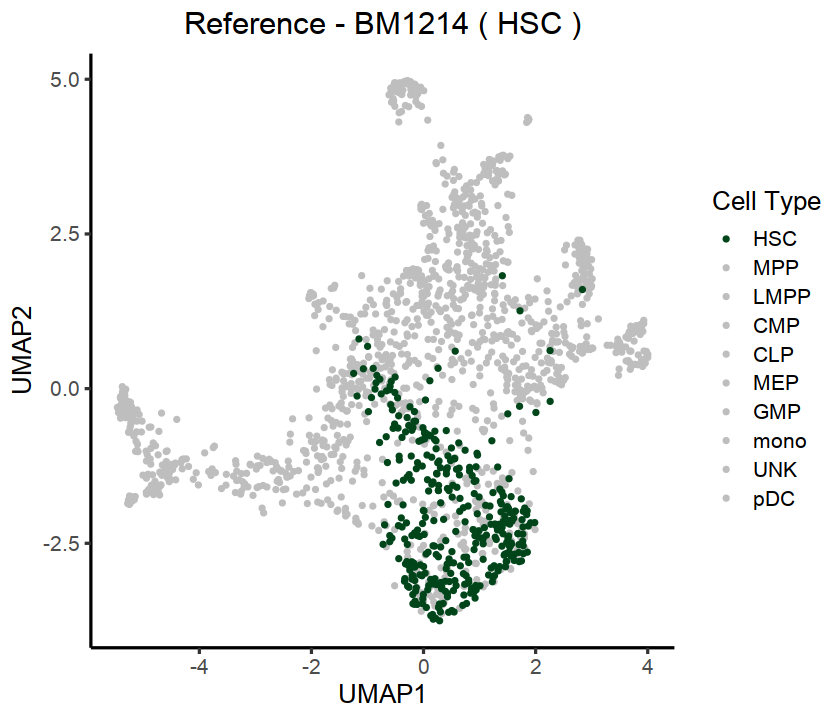

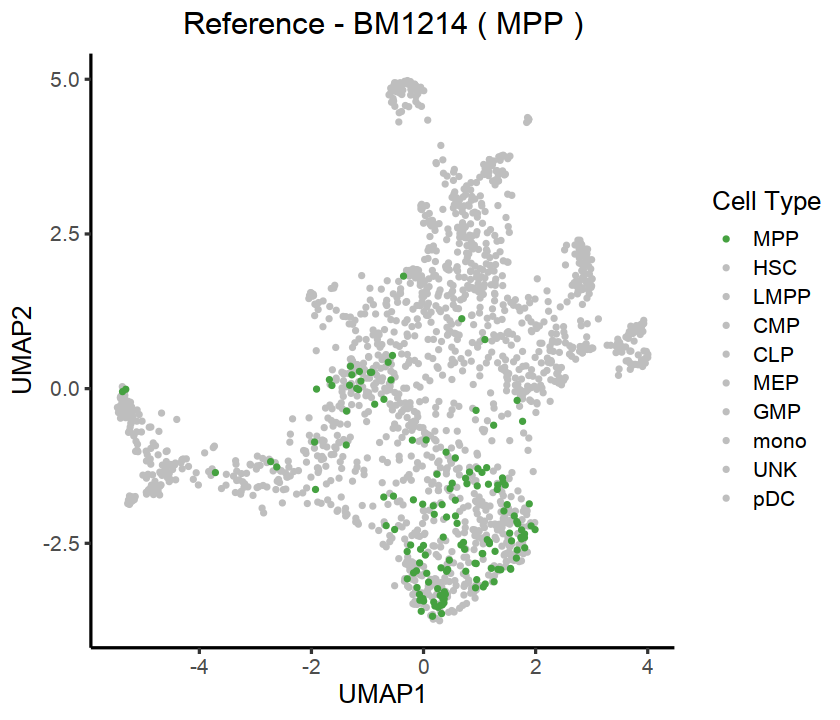

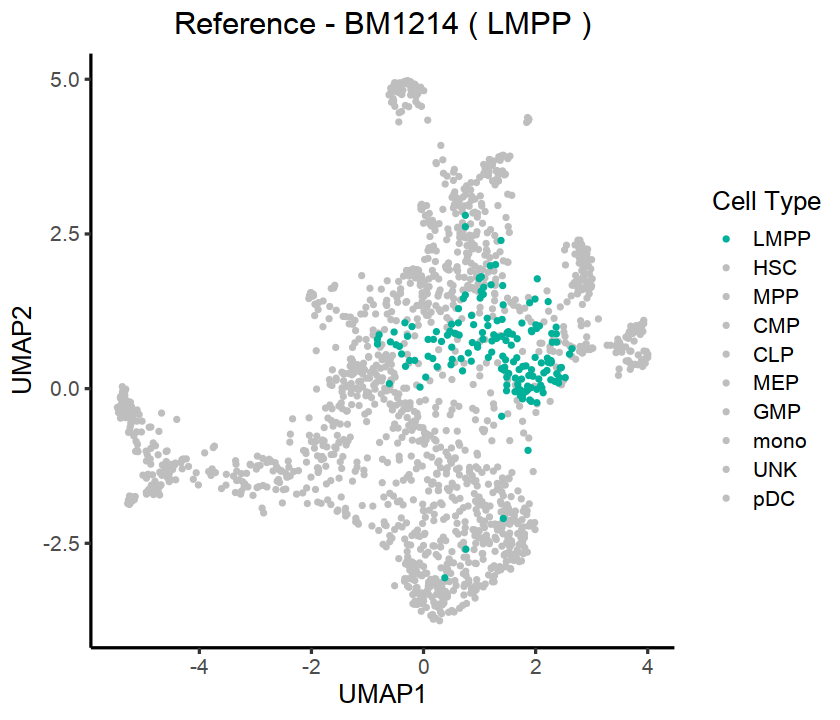

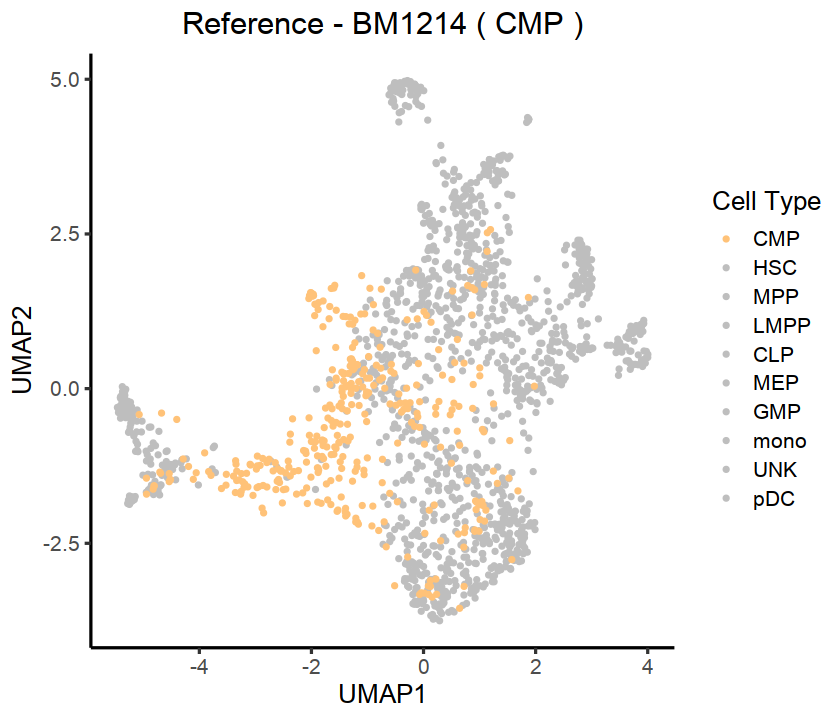

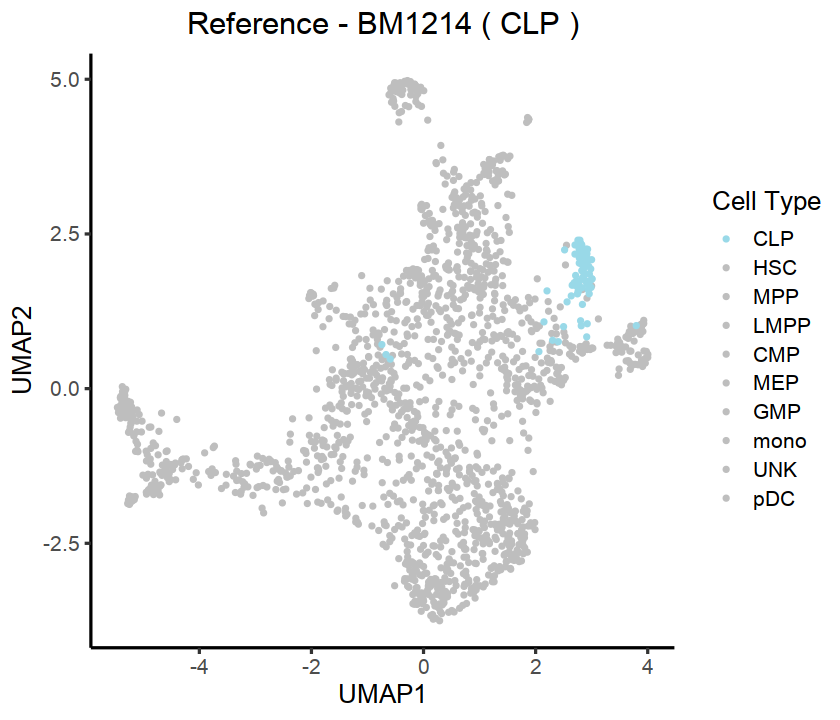

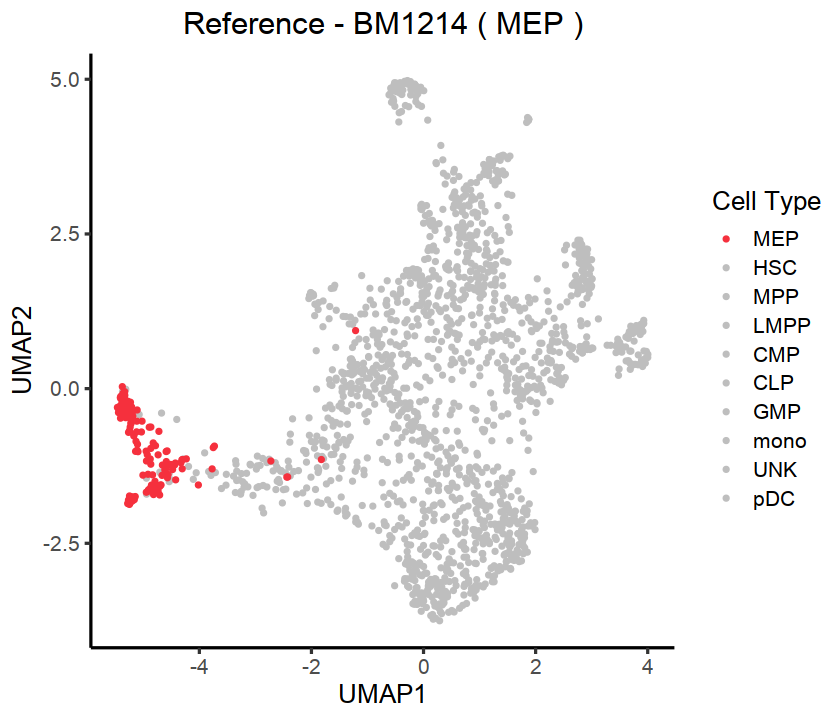

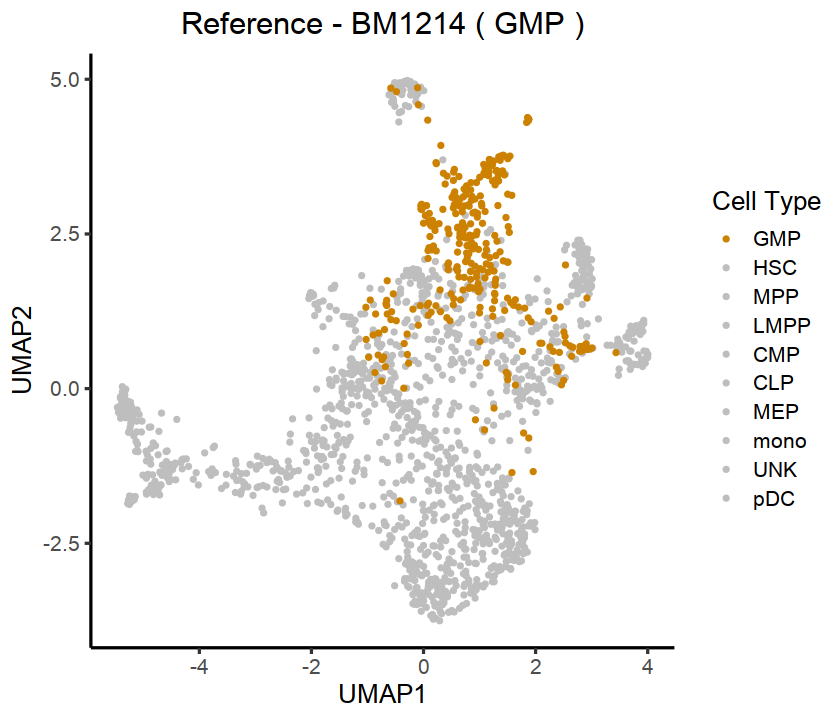

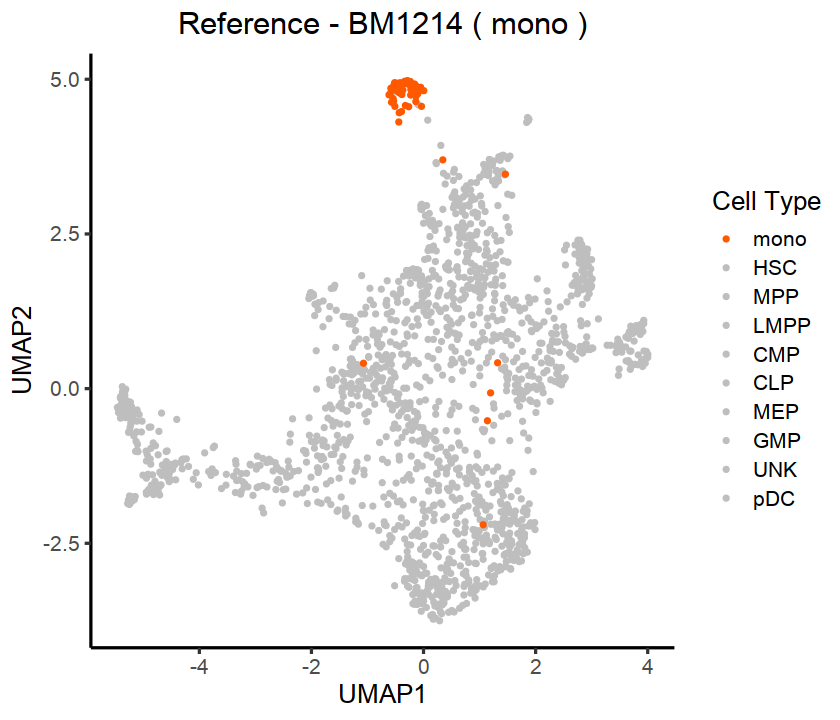

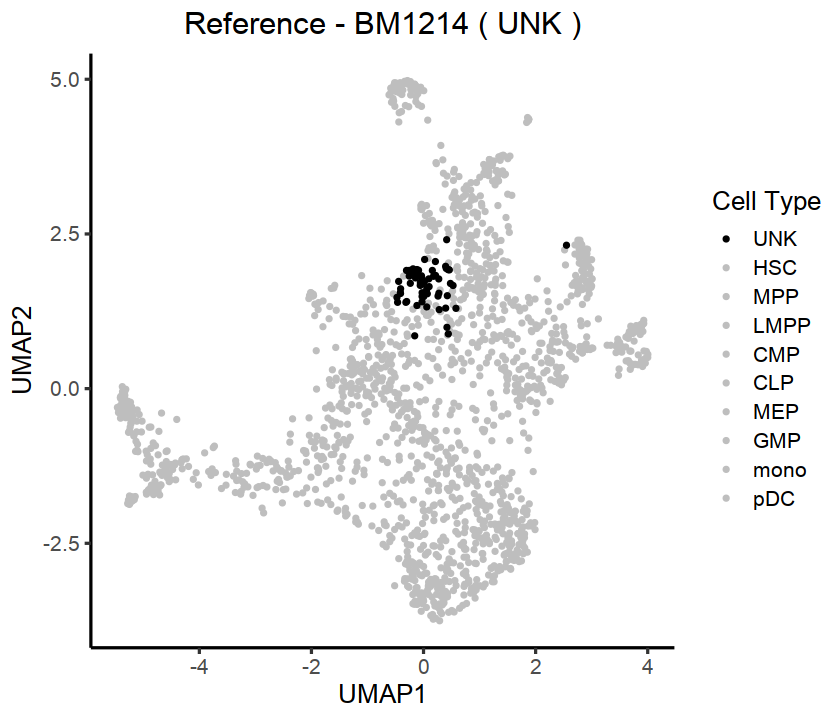

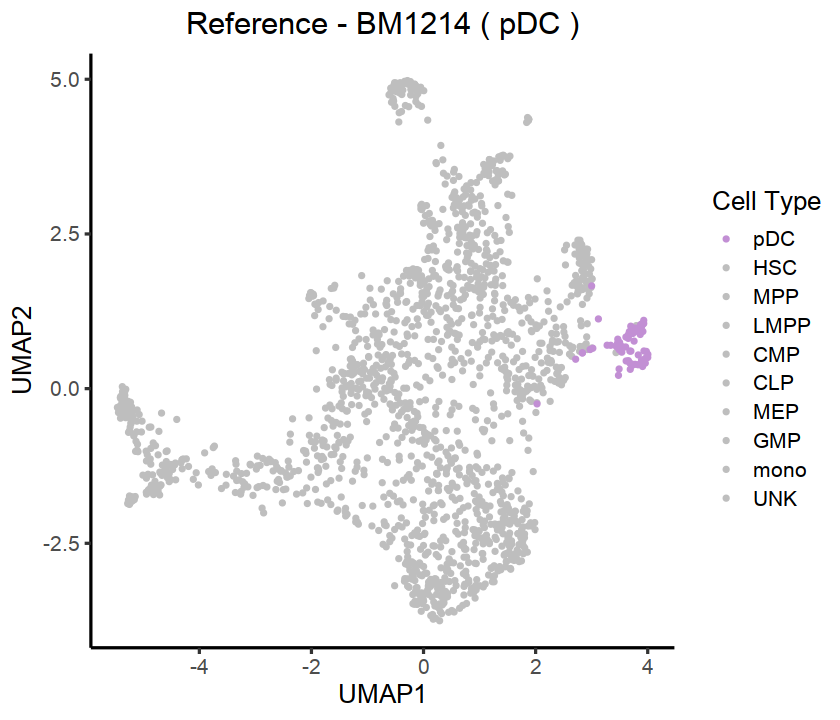

In [23]:
options(repr.plot.height=6,repr.plot.width=7)
indivCT_dir <- paste(sep='',outDir,prefix,'_individualCT/')
dir.create(indivCT_dir,showWarnings=FALSE)
for(CT in names(cell_color)){
    cell_color_only <- rep('grey',len=length(cell_color))
    names(cell_color_only) <- names(cell_color)
    cell_color_only[CT] <- cell_color[CT]
    
    toPlot <- umap_labels[1:nrow(umap_labels),1:ncol(umap_labels)]
    toPlot[,cellType_col] <- factor(toPlot[,cellType_col],levels=c(CT,names(cell_color)[which(names(cell_color)!=CT)]))
    toPlot <- toPlot[order(toPlot[,cellType_col],decreasing=TRUE),]
    
    g <- ggplot(toPlot,aes_string(x='UMAP1',y='UMAP2',color=cellType_col)) + geom_point(size=1) +
            theme_classic(base_size=15) + scale_color_manual(values=cell_color_only) + labs(color='Cell Type') + 
            ggtitle(paste('Reference -',prefix,'(',CT,')')) + theme(plot.title = element_text(hjust = 0.5))
    print(g)
    ggsave(paste(sep='',indivCT_dir,prefix,'_ref_UMAP-cellType-',CT,'.pdf'),plot=g,units='in',height=6, width=7)
}

### color by donor

In [24]:
donor_color <- c('BM4983'='red','BM0106'='blue','BM0828'='green','PB1022'='orange',
                 'BM1077'='khaki3','BM1137'='brown','BM1214'='hotpink')

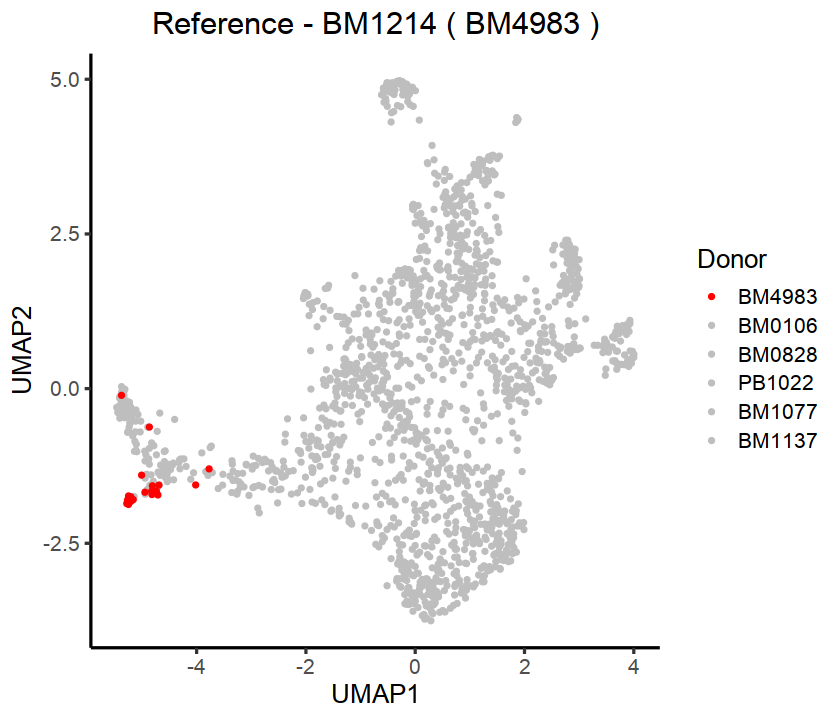

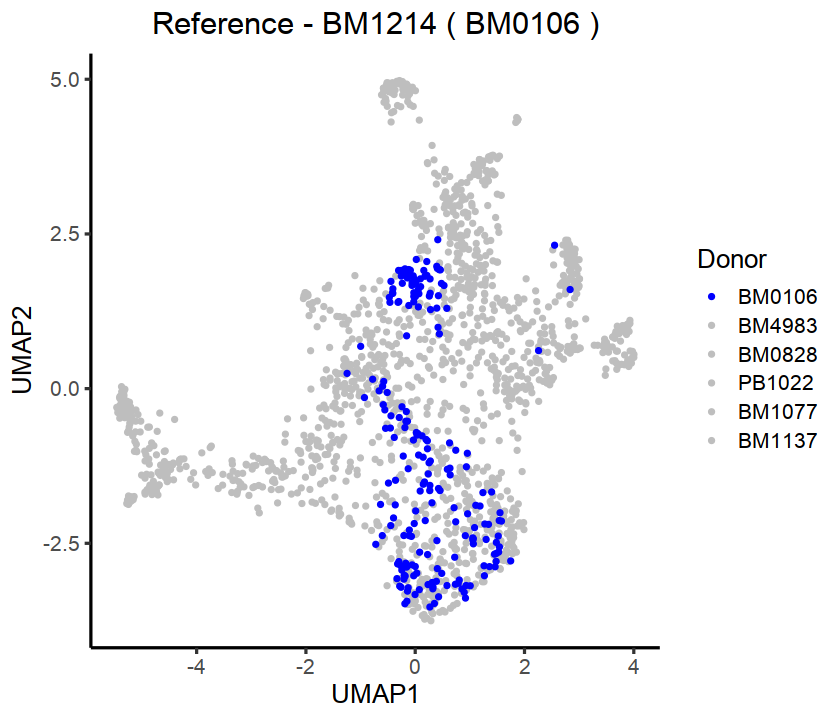

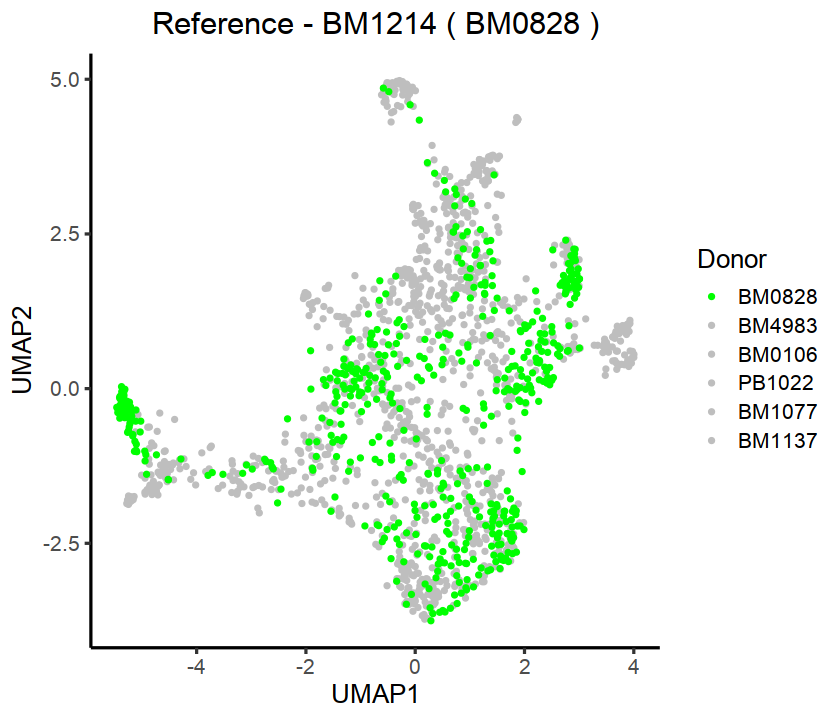

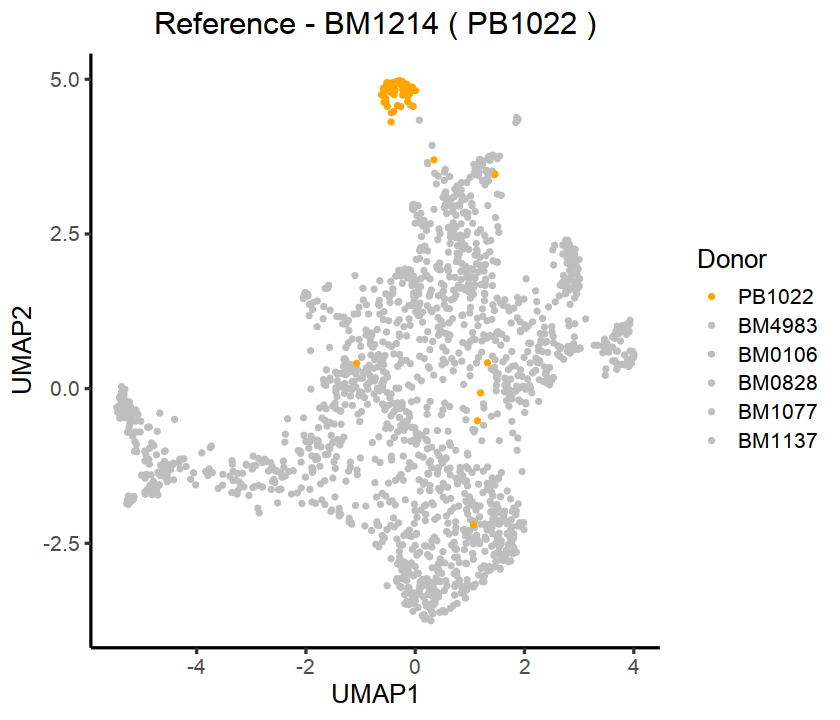

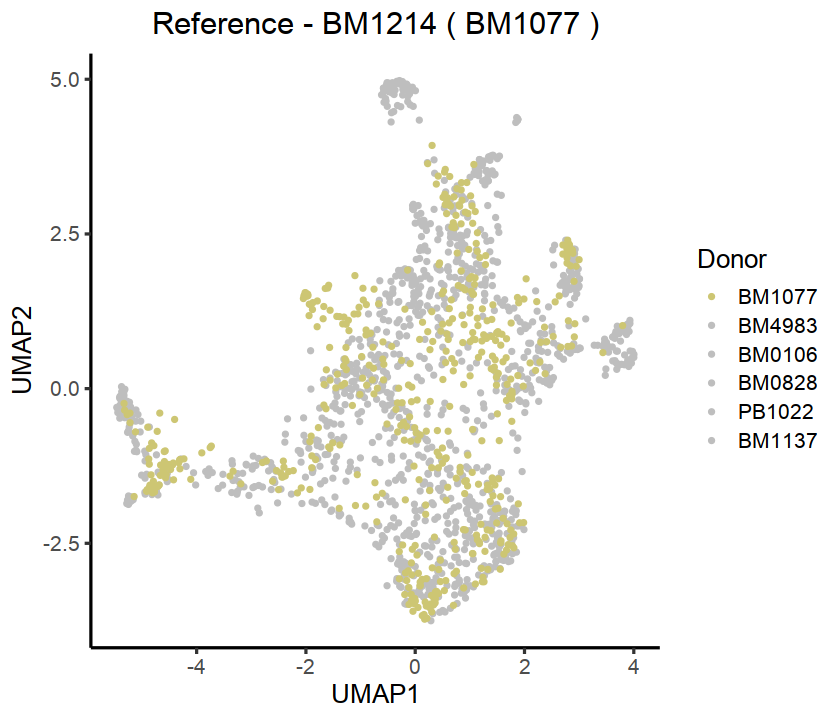

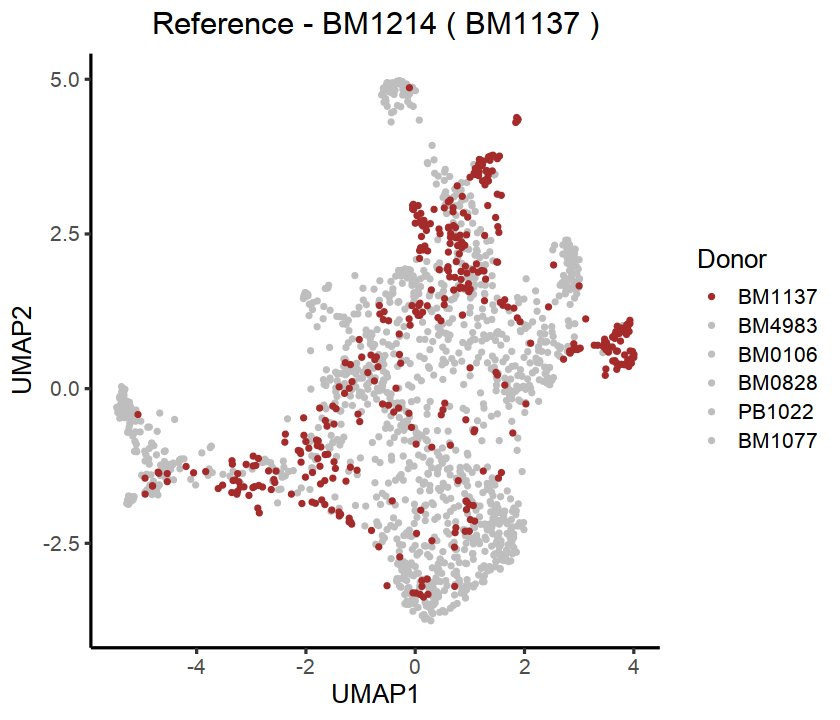

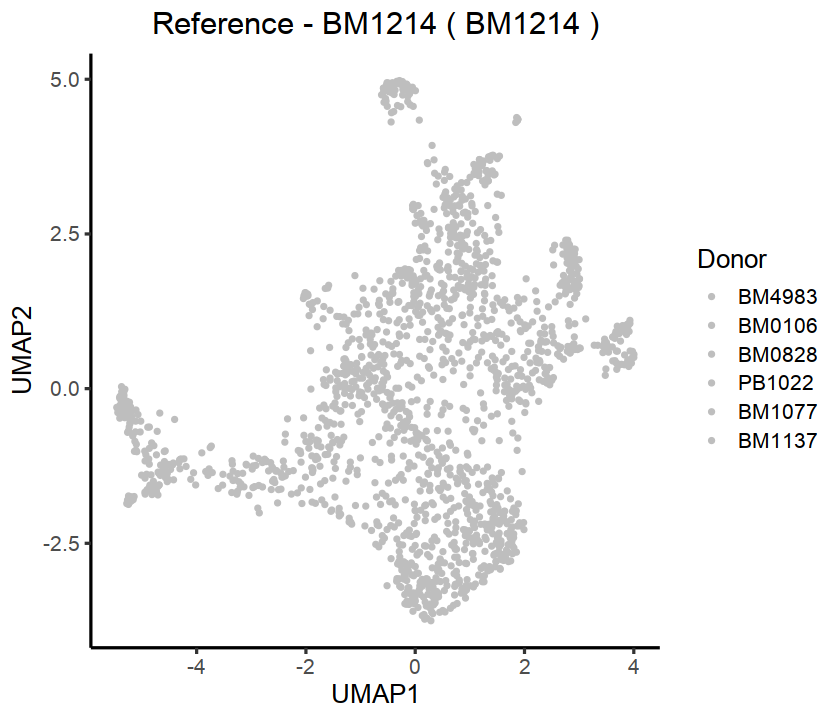

In [25]:
options(repr.plot.height=6,repr.plot.width=7)
indivDonor_dir <- paste(sep='',outDir,prefix,'_individualDonor/')
dir.create(indivDonor_dir,showWarnings=FALSE)
for(donor in names(donor_color)){
    donor_color_only <- rep('grey',len=length(donor_color))
    names(donor_color_only) <- names(donor_color)
    donor_color_only[donor] <- donor_color[donor]
    
    toPlot <- umap_labels[1:nrow(umap_labels),1:ncol(umap_labels)]
    toPlot$donor <- factor(toPlot$donor,levels=c(donor,names(donor_color)[which(names(donor_color)!=donor)]))
    toPlot <- toPlot[order(toPlot$donor,decreasing=TRUE),]
    
    g <- ggplot(toPlot,aes_string(x='UMAP1',y='UMAP2',color='donor')) + geom_point(size=1) +
            theme_classic(base_size=15) + scale_color_manual(values=donor_color_only) + labs(color='Donor') + 
            ggtitle(paste('Reference -',prefix,'(',donor,')')) + theme(plot.title = element_text(hjust = 0.5))
    print(g)
    ggsave(paste(sep='',indivDonor_dir,prefix,'_ref_UMAP-donor-',donor,'.pdf'),plot=g,units='in',height=6, width=7)
}

## map query

In [26]:
# Map query
query = mapQuery2(query_pxc,             # query peak counts (peaks x cells)
                  query_metadata,        # query metadata (cells x attributes)
                  reference,             # Symphony reference object
                  do_normalize = FALSE,  # perform log(CP10k) normalization on query - no, will normalize with TF-IDF
                  do_umap = TRUE)        # project query cells into reference UMAP

Normalizing and synchronizing query peak counts

Found 6320 reference variable peaks in query dataset

Performing TF-IDF normalization

Using provided IDF

Project query cells using reference gene loadings

Clustering query cells to reference centroids

Correcting query batch effects

UMAP

All done!



In [27]:
str(query)

List of 7
 $ exp      :Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  .. ..@ i       : int [1:1650749] 158 241 274 289 552 587 827 1106 1333 1513 ...
  .. ..@ p       : int [1:299] 0 3042 8719 13870 25304 32319 37823 39736 42078 44702 ...
  .. ..@ Dim     : int [1:2] 237450 298
  .. ..@ Dimnames:List of 2
  .. .. ..$ : chr [1:237450] "chr1:10295-10744" "chr1:13278-13727" "chr1:16025-16474" "chr1:96376-96825" ...
  .. .. ..$ : chr [1:298] "singles-BM1214-MCP-frozen-160128-1" "singles-BM1214-MCP-frozen-160128-2" "singles-BM1214-MCP-frozen-160128-3" "singles-BM1214-MCP-frozen-160128-4" ...
  .. ..@ x       : num [1:1650749] 1 1 1 1 1 1 1 1 1 1 ...
  .. ..@ factors : list()
 $ meta_data:'data.frame':	298 obs. of  5 variables:
  ..$ cell     : chr [1:298] "singles-BM1214-MCP-frozen-160128-1" "singles-BM1214-MCP-frozen-160128-2" "singles-BM1214-MCP-frozen-160128-3" "singles-BM1214-MCP-frozen-160128-4" ...
  ..$ buenCT   : chr [1:298] "MCP" "MCP" "MCP" "MCP" ...
  ..$ cellType : c

In [28]:
set.seed(0)
query = knnPredict(query, reference, reference$meta_data[,cellType_col], k = 5, confidence=TRUE)

In [29]:
query$meta_data$correct <- FALSE
query$meta_data[which(query$meta_data[,cellType_col]==query$meta_data$cell_type_pred_knn),'correct'] <- TRUE

In [30]:
head(query$meta_data)

,cell,buenCT,cellType,donor,readDepth,cell_type_pred_knn,cell_type_pred_knn_prob,correct
,<chr>,<chr>,<chr>,<chr>,<int>,<fct>,<dbl>,<lgl>
singles-BM1214-MCP-frozen-160128-1,singles-BM1214-MCP-frozen-160128-1,MCP,pDC,BM1214,11460,CLP,0.6,FALSE
singles-BM1214-MCP-frozen-160128-2,singles-BM1214-MCP-frozen-160128-2,MCP,pDC,BM1214,32893,pDC,1.0,TRUE
singles-BM1214-MCP-frozen-160128-3,singles-BM1214-MCP-frozen-160128-3,MCP,pDC,BM1214,17160,LMPP,0.6,FALSE
singles-BM1214-MCP-frozen-160128-4,singles-BM1214-MCP-frozen-160128-4,MCP,pDC,BM1214,57515,pDC,1.0,TRUE
singles-BM1214-MCP-frozen-160128-5,singles-BM1214-MCP-frozen-160128-5,MCP,pDC,BM1214,36837,HSC,0.4,FALSE
singles-BM1214-MCP-frozen-160128-6,singles-BM1214-MCP-frozen-160128-6,MCP,pDC,BM1214,17667,pDC,1.0,TRUE


## compare predicted to 'known' cell type

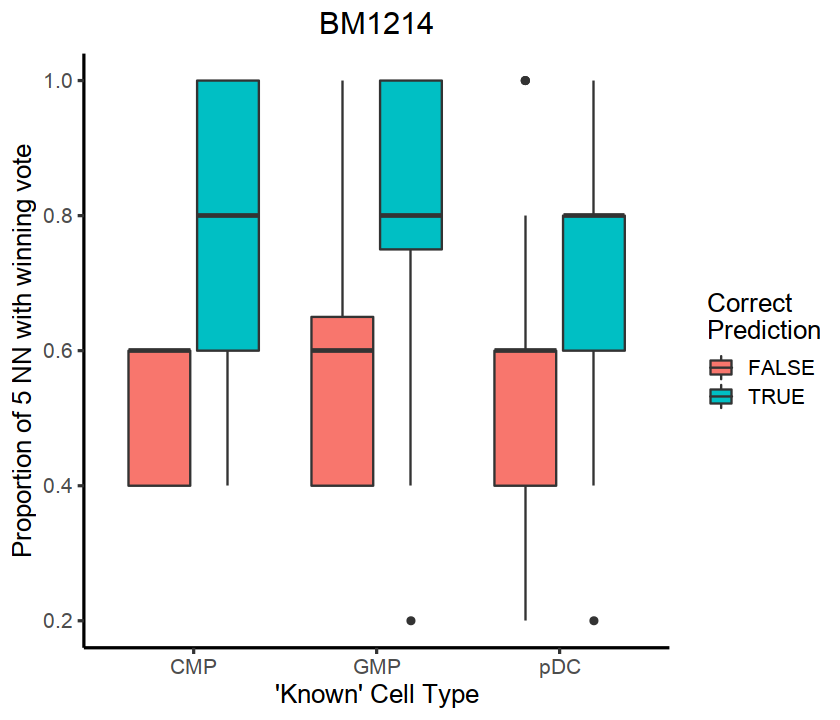

In [31]:
options(repr.plot.height=6,repr.plot.width=7)
g <- ggplot(query$meta_data,aes_string(x=cellType_col,y='cell_type_pred_knn_prob',fill='correct')) + geom_boxplot() + 
        labs(x="'Known' Cell Type",y='Proportion of 5 NN with winning vote',fill='Correct\nPrediction') +
        theme_classic(base_size=15) +
        ggtitle(prefix) + theme(plot.title = element_text(hjust = 0.5))
print(g)
ggsave(paste(sep='',outDir,prefix,'_query_proportionNN.pdf'),plot=g,units='in',height=6, width=7)

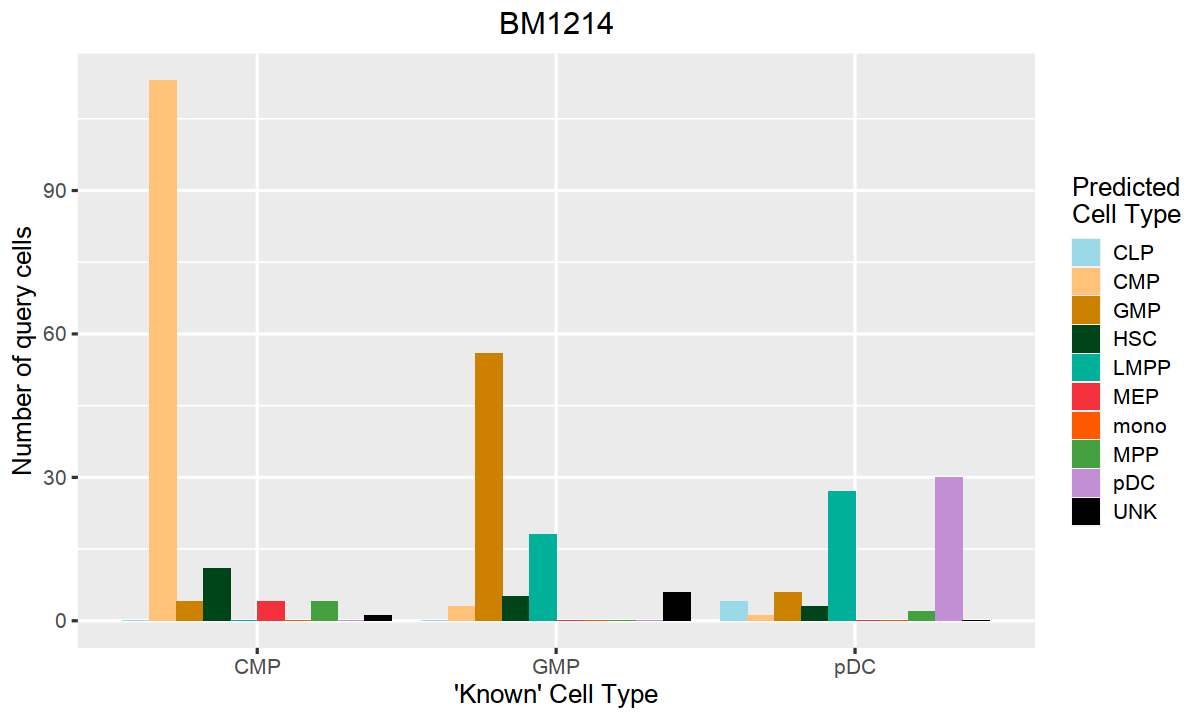

In [32]:
options(repr.plot.height=6,repr.plot.width=10)
toPlot <- as.data.frame(table(query$meta_data[c(cellType_col,'cell_type_pred_knn')]))
g <- ggplot(toPlot,aes_string(x=cellType_col,y='Freq',fill='cell_type_pred_knn')) + 
        geom_bar(position="dodge", stat="identity") + scale_fill_manual(values=cell_color) +
        labs(x="'Known' Cell Type",fill='Predicted\nCell Type',y='Number of query cells') +
        theme_grey(base_size=15) +
        ggtitle(prefix) + theme(plot.title = element_text(hjust = 0.5))
print(g)
ggsave(paste(sep='',outDir,prefix,'_refQuery_predictedCT.pdf'),plot=g,units='in',height=6, width=10)

## combine reference and query

In [33]:
# Sync the column names for both data frames
reference$meta_data$cell_type_pred_knn = NA
reference$meta_data$cell_type_pred_knn_prob = NA
reference$meta_data$correct = NA
reference$meta_data$ref_query = 'reference'
query$meta_data$ref_query = 'query'

# Add the UMAP coordinates to the metadata
meta_data_combined = rbind(query$meta_data, reference$meta_data)
umap_combined = rbind(query$umap, reference$umap$embedding)
umap_combined_labels = cbind(meta_data_combined, umap_combined)

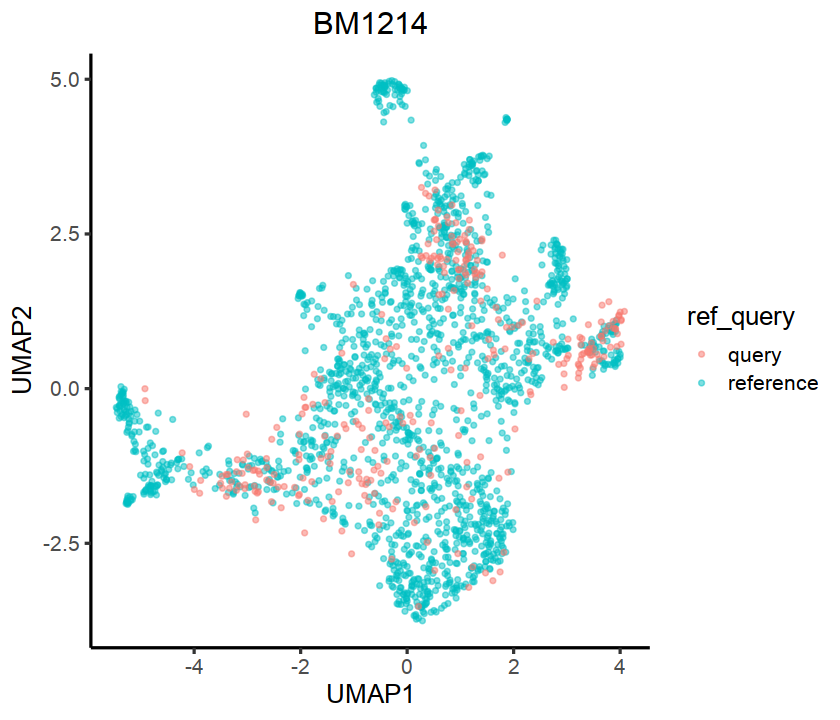

In [34]:
options(repr.plot.height=6,repr.plot.width=7)
toPlot <- umap_combined_labels[1:nrow(umap_combined_labels),1:ncol(umap_combined_labels)]
toPlot$ref_query <- factor(toPlot$ref_query,levels=c('query','reference'))
toPlot <- toPlot[order(toPlot$ref_query,decreasing=TRUE),]
g <- ggplot(toPlot,aes_string(x='UMAP1',y='UMAP2',color='ref_query')) + geom_point(size=1,alpha=0.5) +
        theme_classic(base_size=15) + ggtitle(paste(prefix)) + theme(plot.title = element_text(hjust = 0.5))
print(g)
ggsave(paste(sep='',outDir,prefix,'_refQuery_UMAP.pdf'),plot=g,units='in',height=6, width=7)

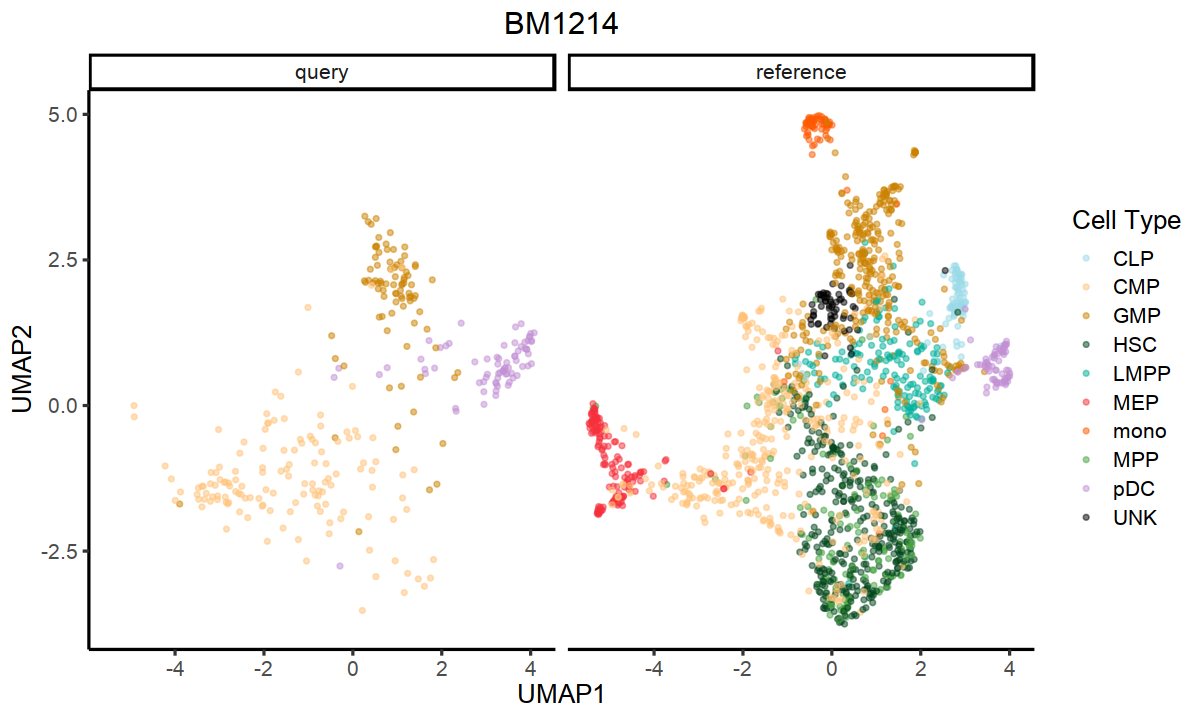

In [35]:
options(repr.plot.height=6,repr.plot.width=10)
g <- ggplot(umap_combined_labels,aes_string(x='UMAP1',y='UMAP2',color=cellType_col)) + geom_point(size=1,alpha=0.5) +
        theme_classic(base_size=15) + scale_color_manual(values=cell_color) + labs(color='Cell Type') + 
        facet_grid(.~ref_query) + ggtitle(paste(prefix)) + theme(plot.title = element_text(hjust = 0.5))
print(g)
ggsave(paste(sep='',outDir,prefix,'_refQuery_UMAP-cellType.pdf'),plot=g,units='in',height=6, width=10)

In [36]:
cell_color_only <- rep('grey',len=length(cell_color))
names(cell_color_only) <- names(cell_color)
for(CT in unique(query_metadata[,cellType_col])){
    cell_color_only[CT] <- cell_color[CT]
}

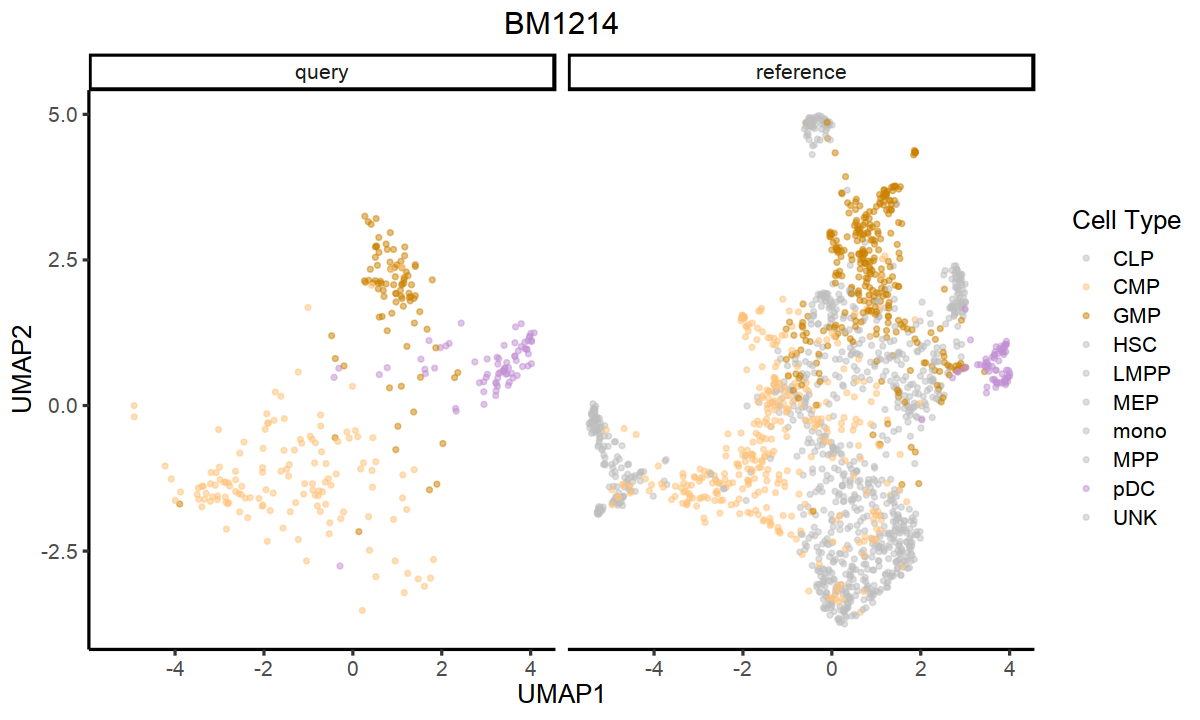

In [37]:
options(repr.plot.height=6,repr.plot.width=10)
g <- ggplot(umap_combined_labels,aes_string(x='UMAP1',y='UMAP2',color=cellType_col)) + geom_point(size=1,alpha=0.5) +
        theme_classic(base_size=15) + scale_color_manual(values=cell_color_only) + labs(color='Cell Type') + 
        facet_grid(.~ref_query) + ggtitle(paste(prefix)) + theme(plot.title = element_text(hjust = 0.5))
print(g)
ggsave(paste(sep='',outDir,prefix,'_refQuery_UMAP-cellType_grey.pdf'),plot=g,units='in',height=6, width=10)

## Done!

In [38]:
sessionInfo()

R version 3.6.1 (2019-07-05)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Red Hat Enterprise Linux Server release 6.5 (Santiago)

Matrix products: default
BLAS/LAPACK: /PHShome/kew47/miniconda3/lib/R/lib/libRblas.so

locale:
[1] en_US.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] Seurat_3.2.0            repr_1.0.1              ggpubr_0.4.0           
 [4] patchwork_1.1.0.9000    RColorBrewer_1.1-2      ggrastr_0.2.3          
 [7] ggthemes_4.2.0          ggplot2_3.3.0           dplyr_1.0.2            
[10] plyr_1.8.6              matrixStats_0.56.0      tidyr_1.0.3            
[13] irlba_2.3.3             Matrix_1.2-18           singlecellmethods_0.1.0
[16] data.table_1.12.8       harmony_1.0             Rcpp_1.0.4.6           
[19] symphony_1.0           

loaded via a namespace (and not attached):
  [1] readxl_1.3.1          uuid_0.1-2            backports_1.1.6      
  [4] igra